# 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import warnings as w
w.filterwarnings('ignore')

C:\Users\derev\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Расчет выбросов статистическим методом
def IQR(x):
    '''Функция для расчета межквартильного размаха'''
    return x.quantile(0.75) - x.quantile(0.25)

def perc25(x):
    '''Функция для расчета нижнего квартиля'''
    return x.quantile(0.25)

def perc75(x):
    '''Функция для расчета верхнего квартиля'''
    return x.quantile(0.75)

def outlier_low(x):
    '''Функция для расчета границы нижнего выброса'''
    return perc25(x) - 1.5*IQR(x)

def outlier_high(x):
    '''Функция для расчета границы верхнего выброса'''
    return perc75(x) + 1.5*IQR(x)

# 2. Импорт данных

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';', decimal=',')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.6,0.08,2,0.09,32,44,0.9949,3.45,0.58,10.5,5
1595,5.9,0.55,0.1,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
1596,6.3,0.51,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11,6
1597,5.9,0.645,0.12,2,0.075,32,44,0.99547,3.57,0.71,10.2,5


In [4]:
# Преобразуем наименование признаков, удалим пробелы
df.columns = [x.replace(" ", "_") for x in df.columns.to_list()]
df.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5


In [5]:
# Посмотрим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed_acidity         1599 non-null   object
 1   volatile_acidity      1599 non-null   object
 2   citric_acid           1599 non-null   object
 3   residual_sugar        1599 non-null   object
 4   chlorides             1599 non-null   object
 5   free_sulfur_dioxide   1599 non-null   object
 6   total_sulfur_dioxide  1599 non-null   object
 7   density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   sulphates             1599 non-null   object
 10  alcohol               1599 non-null   object
 11  quality               1599 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 150.0+ KB


In [6]:
# Преобразуем типы строк на float 
columns_to_float = df.iloc[:, :-1].columns.to_list()
for col in tqdm(columns_to_float):
    df[col] = df[col].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
# Проверим пропуски
df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**Вывод по данным:**
* Пропусков в данных нет;
* Значнеие признаков:
    - fixed_acidity - общая кислотность вина;
    - volatile_acidity - летучая кислотность вина;
    - citric_acid - содержание в вине лимонной кислоты;
    - residual_sugar - остаточный сахар;
    - chlorides - концентрации хлорида;
    - free_sulfur_dioxide - концентрация свободного диоксида серы;
    - total_sulfur_dioxide - концентрация общего диоксида серы;
    - density - плотность вина;
    - pH - активная кислотность;
    - sulphates - концентрация сульфатов;
    - alcohol - градус алкоголя;
    - quality - оценка качества вина по шкале от 3 до 8.
* Критичных аномалий в данных на первый взгляд не наблюдается. 

# 3. EDA

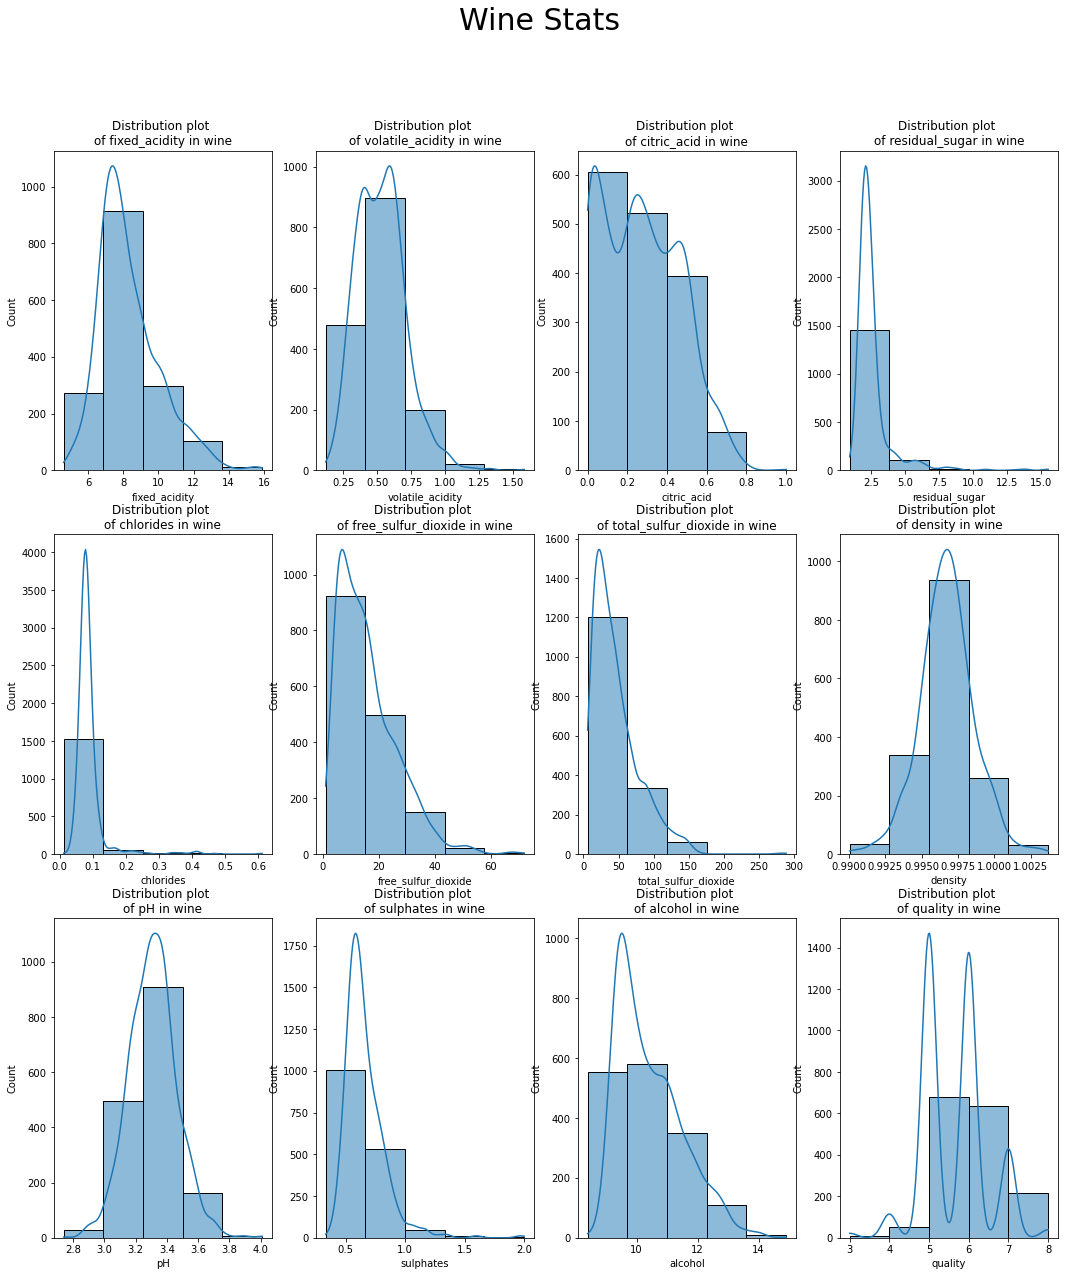

In [10]:
# Посмотрим распредение данныъ на гистограммах с KDE
counter = 0
cols_lst = df.columns.to_list()
fig, axes = plt.subplots(3, 4, figsize=(18, 20))
fig.suptitle('Wine Stats', size=30)
for i in range(0, 3):
    for j in range(0, 4):
        sns.histplot(ax=axes[i, j], data=df, x = cols_lst[counter], bins=5, kde=True)
        axes[i, j].set_title('Distribution plot \nof {} in wine'.format(str(cols_lst[counter])))
        # print(counter, i, j)
        counter +=1
    

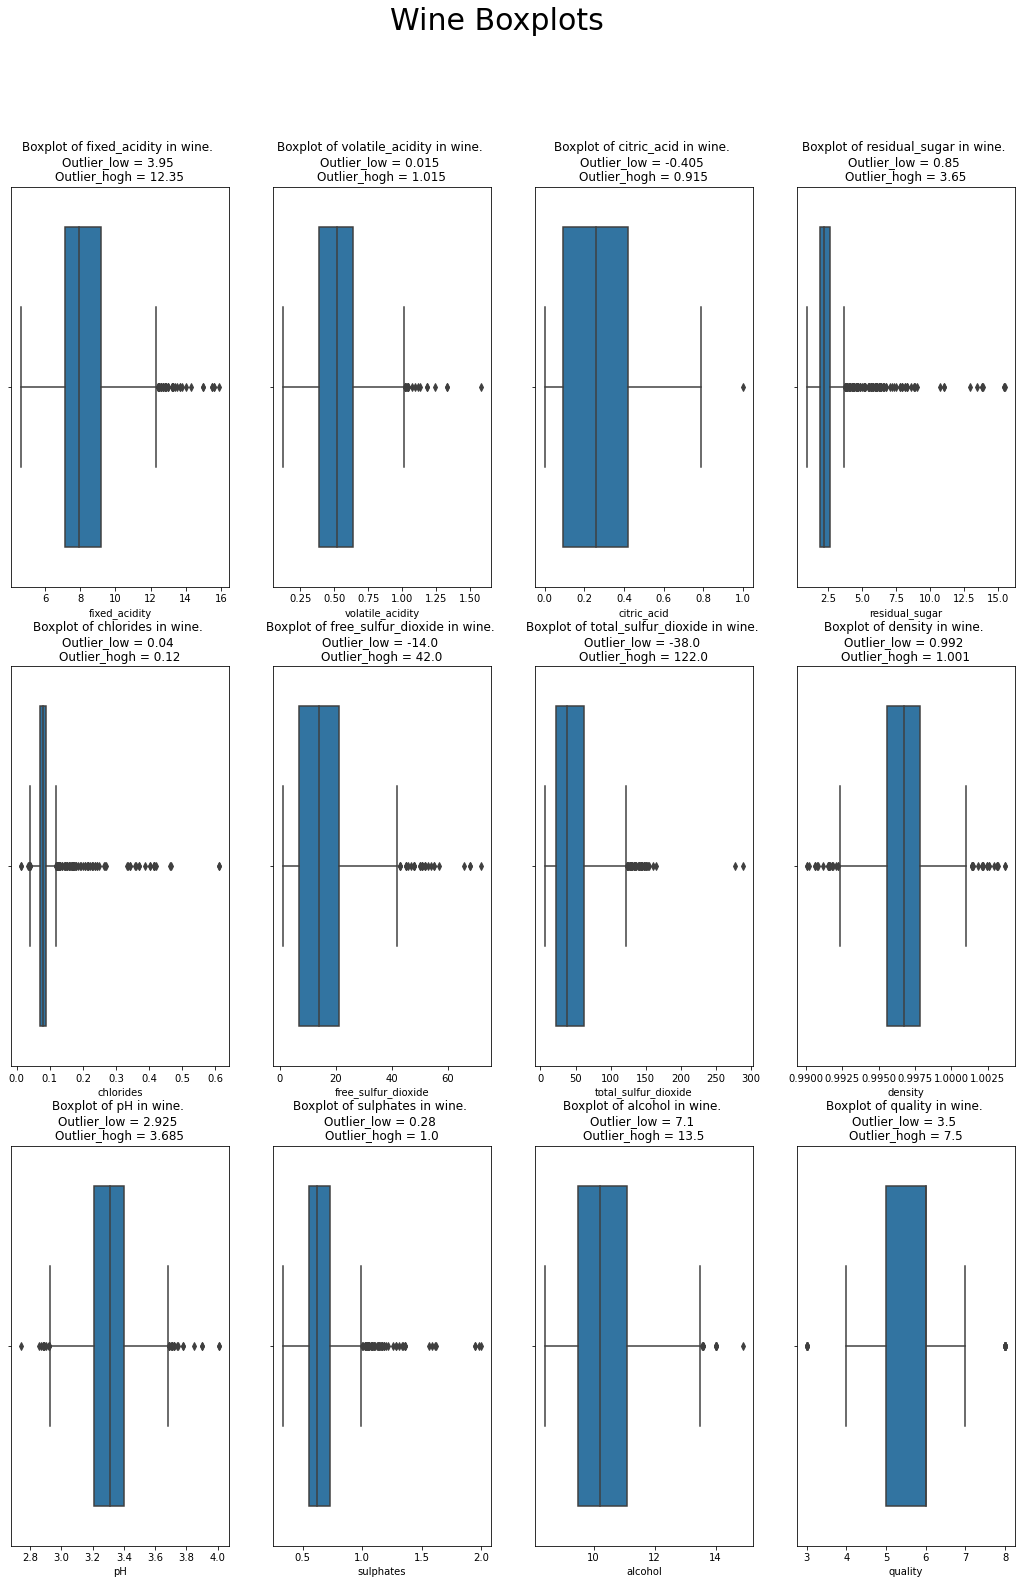

In [11]:
# Посмотрим на выбросы
counter = 0
cols_lst = df.columns.to_list()
fig, axes = plt.subplots(3, 4, figsize=(18, 25))
fig.suptitle('Wine Boxplots', size=30)
for i in range(0, 3):
    for j in range(0, 4):
        sns.boxplot(ax=axes[i, j], data=df, x=cols_lst[counter])
        axes[i, j].set_title('Boxplot of {} in wine. \nOutlier_low = {} \nOutlier_hogh = {}'
                             .format(str(cols_lst[counter]),
                                     np.round(outlier_low(df[cols_lst[counter]]), 3),
                                     np.round(outlier_high(df[cols_lst[counter]]), 3)))
        # print(counter, i, j)
        counter += 1

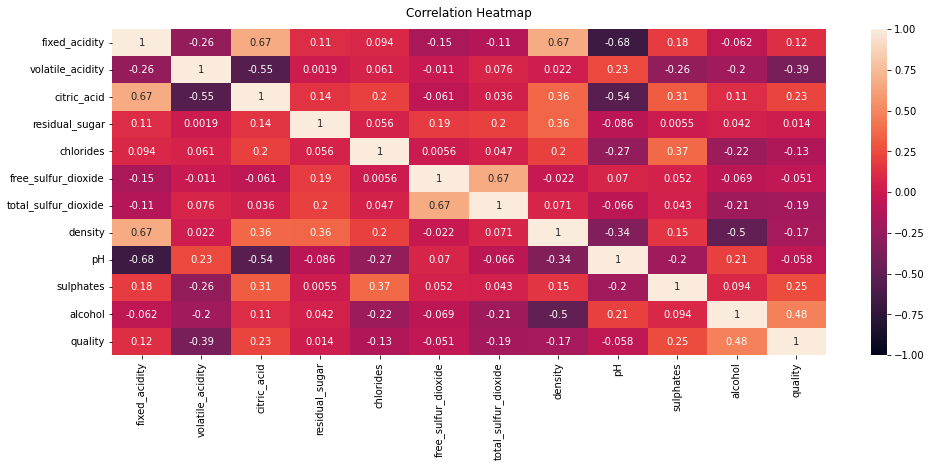

In [12]:
# Посмотрим матрицу корреляции
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [13]:
# Удалим столбцы с низкой крреляцией
df = df.drop(['fixed_acidity', 'residual_sugar', 'free_sulfur_dioxide', 'pH', 'chlorides', 'density'], axis=1)
df.head(5)

,volatile_acidity,citric_acid,total_sulfur_dioxide,sulphates,alcohol,quality
0,0.70,0.00,34.0,0.56,9.4,5
1,0.88,0.00,67.0,0.68,9.8,5
2,0.76,0.04,54.0,0.65,9.8,5
3,0.28,0.56,60.0,0.58,9.8,6
4,0.70,0.00,34.0,0.56,9.4,5


In [14]:
# Удалим выбросы
cols_del_outliers = ['volatile_acidity', 'citric_acid', 'total_sulfur_dioxide', 'sulphates', 'alcohol']
for col in cols_del_outliers:
    print('Feature name: {}'.format(col))
    start_len = len(df)
    print('Num rows before removal: {}'.format(start_len))
    df = df.loc[df[col].between(outlier_low(df[col]), outlier_high(df[col]), inclusive='both')]
    print('Num rows after removal: {}'.format(len(df)))
    print('Num deleted outliers: {}'.format(start_len - len(df)))
    print('-'*40)

Feature name: volatile_acidity
Num rows before removal: 1599
Num rows after removal: 1580
Num deleted outliers: 19
----------------------------------------
Feature name: citric_acid
Num rows before removal: 1580
Num rows after removal: 1579
Num deleted outliers: 1
----------------------------------------
Feature name: total_sulfur_dioxide
Num rows before removal: 1579
Num rows after removal: 1525
Num deleted outliers: 54
----------------------------------------
Feature name: sulphates
Num rows before removal: 1525
Num rows after removal: 1473
Num deleted outliers: 52
----------------------------------------
Feature name: alcohol
Num rows before removal: 1473
Num rows after removal: 1460
Num deleted outliers: 13
----------------------------------------


In [15]:
# Посмотрим количество и диапазон оценок
df['quality'].value_counts()

6    609
5    603
7    182
4     44
8     15
3      7
Name: quality, dtype: int64

In [16]:
# Разделим целевую переменную на 2 класса: bad wine - если оценка < 6, good wine - если оценка >=6
df['quality_class'] = df['quality'].apply(lambda x: 'bad wine' if x < 6 else 'good wine')
df

,volatile_acidity,citric_acid,total_sulfur_dioxide,sulphates,alcohol,quality,quality_class
0,0.700,0.00,34.0,0.56,9.4,5,bad wine
1,0.880,0.00,67.0,0.68,9.8,5,bad wine
2,0.760,0.04,54.0,0.65,9.8,5,bad wine
3,0.280,0.56,60.0,0.58,9.8,6,good wine
4,0.700,0.00,34.0,0.56,9.4,5,bad wine
...,...,...,...,...,...,...,...
1594,0.600,0.08,44.0,0.58,10.5,5,bad wine
1595,0.550,0.10,51.0,0.76,11.2,6,good wine
1596,0.510,0.13,40.0,0.75,11.0,6,good wine
1597,0.645,0.12,44.0,0.71,10.2,5,bad wine


In [17]:
# Сделаем целевую переменную бинарной
le = LabelEncoder()
df['quality'] = le.fit_transform(df['quality_class'])
print(le.classes_)
df

['bad wine' 'good wine']


,volatile_acidity,citric_acid,total_sulfur_dioxide,sulphates,alcohol,quality,quality_class
0,0.700,0.00,34.0,0.56,9.4,0,bad wine
1,0.880,0.00,67.0,0.68,9.8,0,bad wine
2,0.760,0.04,54.0,0.65,9.8,0,bad wine
3,0.280,0.56,60.0,0.58,9.8,1,good wine
4,0.700,0.00,34.0,0.56,9.4,0,bad wine
...,...,...,...,...,...,...,...
1594,0.600,0.08,44.0,0.58,10.5,0,bad wine
1595,0.550,0.10,51.0,0.76,11.2,1,good wine
1596,0.510,0.13,40.0,0.75,11.0,1,good wine
1597,0.645,0.12,44.0,0.71,10.2,0,bad wine


# 4. Feature Engineering 

Попробуем создать новые признаки поделив оставшиеся features в датасете разделив их на 4 категории

* Class 0: X < quantile 25
* Class 1: quantile 25 >= X < quantile 50
* Class 2: quantile 50 >= X < quantile 75
* Class 3: X > quantile 75

In [18]:
for col in df.iloc[:, :-2].columns.to_list():
    perc25 = df[col].quantile(0.25)
    perc50 = df[col].quantile(0.5)
    perc75 = df[col].quantile(0.75)
    df[col+'_class'] = df[col].apply(lambda x: 0 if x < perc25
                                     else 1 if x >= perc25 and x < perc50
                                     else 2 if x >= perc50 and x < perc75
                                     else 3 if x >= perc75 else 0)
    print('Feature name: {}'.format(col))
    print('Min: {}. Max: {}'.format(df[col].min(), df[col].max()))
    print('Class 0: X < {}'.format(perc25))
    print('Class 1: {} >= X < {}'.format(perc25, perc50))
    print('Class 2: {} >= X < {}'.format(perc50, perc75))
    print('Class 3: X > {}'.format(perc75))
    print('-'*40)
df.head(2)

Feature name: volatile_acidity
Min: 0.12. Max: 1.01
Class 0: X < 0.39
Class 1: 0.39 >= X < 0.52
Class 2: 0.52 >= X < 0.63125
Class 3: X > 0.63125
----------------------------------------
Feature name: citric_acid
Min: 0.0. Max: 0.79
Class 0: X < 0.09
Class 1: 0.09 >= X < 0.25
Class 2: 0.25 >= X < 0.42
Class 3: X > 0.42
----------------------------------------
Feature name: total_sulfur_dioxide
Min: 6.0. Max: 122.0
Class 0: X < 21.0
Class 1: 21.0 >= X < 36.0
Class 2: 36.0 >= X < 58.0
Class 3: X > 58.0
----------------------------------------
Feature name: sulphates
Min: 0.33. Max: 0.98
Class 0: X < 0.55
Class 1: 0.55 >= X < 0.62
Class 2: 0.62 >= X < 0.71
Class 3: X > 0.71
----------------------------------------
Feature name: alcohol
Min: 8.4. Max: 13.5
Class 0: X < 9.5
Class 1: 9.5 >= X < 10.2
Class 2: 10.2 >= X < 11.1
Class 3: X > 11.1
----------------------------------------


,volatile_acidity,citric_acid,total_sulfur_dioxide,sulphates,alcohol,quality,quality_class,volatile_acidity_class,citric_acid_class,total_sulfur_dioxide_class,sulphates_class,alcohol_class
0,0.70,0.0,34.0,0.56,9.4,0,bad wine,3,0,1,1,0
1,0.88,0.0,67.0,0.68,9.8,0,bad wine,3,0,3,2,1


In [19]:
# Посмотрим распределение классов целевой переменной
df.quality.value_counts()

1    806
0    654
Name: quality, dtype: int64

In [20]:
# Создадим фиктивные переменные из категорий с помощью get_dummies
df = pd.get_dummies(df, columns=['volatile_acidity_class',
                                 'citric_acid_class', 'total_sulfur_dioxide_class', 'sulphates_class',
                                 'alcohol_class'])

df

,volatile_acidity,citric_acid,total_sulfur_dioxide,sulphates,alcohol,quality,quality_class,volatile_acidity_class_0,volatile_acidity_class_1,volatile_acidity_class_2,...,total_sulfur_dioxide_class_2,total_sulfur_dioxide_class_3,sulphates_class_0,sulphates_class_1,sulphates_class_2,sulphates_class_3,alcohol_class_0,alcohol_class_1,alcohol_class_2,alcohol_class_3
0,0.700,0.00,34.0,0.56,9.4,0,bad wine,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.880,0.00,67.0,0.68,9.8,0,bad wine,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0.760,0.04,54.0,0.65,9.8,0,bad wine,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,0.280,0.56,60.0,0.58,9.8,1,good wine,1,0,0,...,0,1,0,1,0,0,0,1,0,0
4,0.700,0.00,34.0,0.56,9.4,0,bad wine,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0.600,0.08,44.0,0.58,10.5,0,bad wine,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1595,0.550,0.10,51.0,0.76,11.2,1,good wine,0,0,1,...,1,0,0,0,0,1,0,0,0,1
1596,0.510,0.13,40.0,0.75,11.0,1,good wine,0,1,0,...,1,0,0,0,0,1,0,0,1,0
1597,0.645,0.12,44.0,0.71,10.2,0,bad wine,0,0,0,...,1,0,0,0,0,1,0,0,1,0


# 5. Data Preprocessing

In [21]:
# Разделим датасет на train и test
X = df.drop(['quality', 'quality_class'], axis=1)
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('y_train value counts: \n{}'.format(y_train.value_counts()))
print('y_test value counts: \n{}'.format(y_test.value_counts()))

(1168, 25) (292, 25) (1168,) (292,)
y_train value counts: 
1    645
0    523
Name: quality, dtype: int64
y_test value counts: 
1    161
0    131
Name: quality, dtype: int64


In [22]:
# Масштабирование данных
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[['volatile_acidity', 'citric_acid', 'total_sulfur_dioxide', 'sulphates',
                'alcohol']] = scale.fit_transform(X_train_scaled[['volatile_acidity', 'citric_acid', 'total_sulfur_dioxide',
                                                                  'sulphates', 'alcohol']])

X_test_scaled[['volatile_acidity', 'citric_acid', 'total_sulfur_dioxide', 'sulphates',
               'alcohol']] = scale.transform(X_test_scaled[['volatile_acidity', 'citric_acid', 'total_sulfur_dioxide',
                                                            'sulphates', 'alcohol']])

In [23]:
X_test_scaled

,volatile_acidity,citric_acid,total_sulfur_dioxide,sulphates,alcohol,volatile_acidity_class_0,volatile_acidity_class_1,volatile_acidity_class_2,volatile_acidity_class_3,citric_acid_class_0,...,total_sulfur_dioxide_class_2,total_sulfur_dioxide_class_3,sulphates_class_0,sulphates_class_1,sulphates_class_2,sulphates_class_3,alcohol_class_0,alcohol_class_1,alcohol_class_2,alcohol_class_3
1499,1.329649,-1.251942,-0.998262,-0.057191,1.060410,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
1436,-0.830003,0.589110,1.809614,0.112349,-1.875337,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
211,1.239663,-0.147311,0.747174,-0.650579,-0.407463,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
159,0.489784,-0.462920,1.657837,-0.565809,-1.092471,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
527,-0.830003,1.167726,1.619892,1.129586,0.962552,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.530052,-1.304544,-0.542931,1.468665,0.179686,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1554,2.019538,-1.304544,-0.732653,-0.311500,0.571119,0,0,0,1,1,...,0,0,0,1,0,0,0,0,1,0
497,-1.069965,0.273501,2.682332,1.299125,0.668977,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
256,-1.069965,0.536508,-1.112095,-0.141960,-1.190330,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


# 6. Логистическая регрессия

In [24]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
cv = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('Cross_val_score: {}'.format(cv))
print('Cross_val_score MEAN: {}'.format(cv.mean()))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_lr)))

Cross_val_score: [0.76495726 0.71367521 0.71367521 0.74248927 0.74248927]
Cross_val_score MEAN: 0.735457246616045
Accuracy: 0.7431506849315068


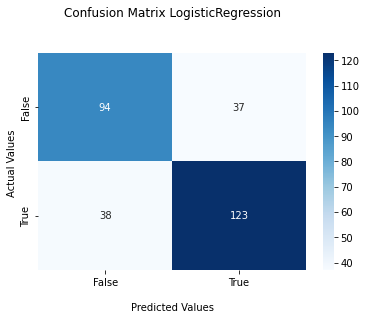

In [25]:
# Посмотрим confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, cmap='Blues', fmt='.3g')
ax.set_title('Confusion Matrix LogisticRegression\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.rcParams['figure.figsize']=(6,6)
plt.show()

In [26]:
0.7404623824451411

0.7404623824451411

In [27]:
0.7329643416927899

0.7329643416927899

# 7. SVM RBF

In [28]:
svc = SVC(probability = True, random_state=1)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
cv = cross_val_score(svc, X_train_scaled, y_train, cv=5)
print('Cross_val_score: {}'.format(cv))
print('Cross_val_score MEAN: {}'.format(cv.mean()))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_svc)))

Cross_val_score: [0.76923077 0.73076923 0.73931624 0.73390558 0.73390558]
Cross_val_score MEAN: 0.7414254796229045
Accuracy: 0.726027397260274


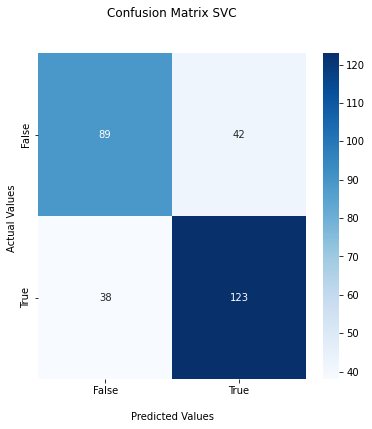

In [29]:
# Посмотрим confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, cmap='Blues', fmt='.3g')
ax.set_title('Confusion Matrix SVC\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.rcParams['figure.figsize']=(6,6)
plt.show()

# 8. Xgboost

In [30]:
xgb = XGBClassifier(random_state=1, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
cv = cross_val_score(xgb, X_train_scaled, y_train, cv=5)
print('Cross_val_score: {}'.format(cv))
print('Cross_val_score MEAN: {}'.format(cv.mean()))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_xgb)))

Cross_val_score: [0.80769231 0.77350427 0.7991453  0.79399142 0.76824034]
Cross_val_score MEAN: 0.7885147279997066
Accuracy: 0.7876712328767124


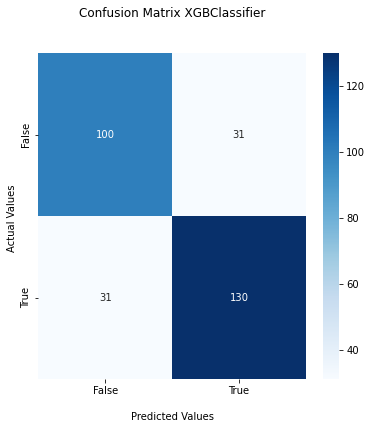

In [31]:
# Посмотрим confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap='Blues', fmt='.3g')
ax.set_title('Confusion Matrix XGBClassifier\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.rcParams['figure.figsize']=(6,6)
plt.show()

In [32]:
# Проверим вычисления
counter_false_0 = 0
counter_true_0 = 0
counter_false_1 = 0
counter_true_1 = 0
for i in np.hstack((np.array([y_test]).reshape(-1,1) , y_pred_xgb.reshape(-1,1))):
    if i[0]==i[1] and i[0]==0:
        counter_true_0 +=1
    elif i[0]==i[1] and i[0]==1:
        counter_true_1 +=1
    elif i[0]!=i[1] and i[0]==0:
        counter_false_0 +=1    
    else:
        counter_false_1 +=1

print('counter_true_0 TN: {}'.format(counter_true_0))
print('counter_true_1 TP: {}'.format(counter_true_1))
print('counter_false_0 FN: {}'.format(counter_false_0))
print('counter_false_1 FP: {}'.format(counter_false_1))

counter_true_0 TN: 100
counter_true_1 TP: 130
counter_false_0 FN: 31
counter_false_1 FP: 31


# 9. SVM RBF GridSearchCV

In [33]:
svc = SVC(random_state=1)
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(C=C_range, gamma=gamma_range)
grid_svc = GridSearchCV(svc, param_grid=param_grid, cv=5)
grid_svc.fit(X_train_scaled,y_train)
y_pred_svc_gs = grid_svc.predict(X_test_scaled)

In [39]:
# Лучшие параметры ядра
grid_svc.best_params_

{'C': 100.0, 'gamma': 0.1}

In [38]:
print('Cross_val_score: {}'.format(grid_svc.cv_results_['mean_test_score']))
print('Cross_val_score MEAN: {}'.format(grid_svc.cv_results_['mean_test_score'].mean()))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_svc_gs)))

Cross_val_score: [0.55222846 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846
 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846
 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846
 0.55222846 0.55222846 0.73805436 0.74318257 0.55222846 0.55222846
 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846 0.55222846
 0.55222846 0.55222846 0.73804703 0.73459888 0.74228018 0.73628627
 0.67891127 0.64981842 0.64468288 0.55222846 0.55222846 0.55222846
 0.55222846 0.55222846 0.73804703 0.73030703 0.73631928 0.74141447
 0.74144015 0.68403947 0.64896005 0.64468288 0.55222846 0.55222846
 0.55222846 0.55222846 0.73804703 0.73030336 0.73288214 0.7371373
 0.74740839 0.74315322 0.68403947 0.64896005 0.64468288 0.55222846
 0.55222846 0.55222846 0.73804703 0.73030336 0.72604086 0.73631195
 0.72601885 0.74144749 0.74229852 0.68403947 0.64896005 0.64468288
 0.55222846 0.55222846 0.73890173 0.73030336 0.72432779 0.72774293
 0.74397491 0.74655735 0.73885404 0.74229852 0

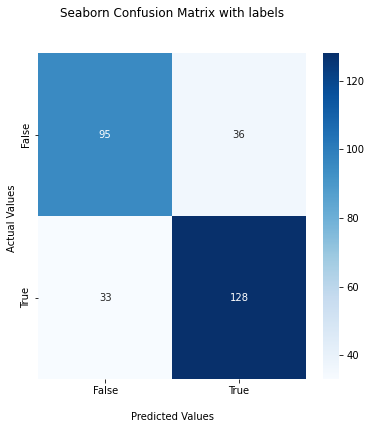

In [35]:
# Посмотрим confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred_svc_gs), annot=True, cmap='Blues', fmt='.3g')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.rcParams['figure.figsize']=(6,6)
plt.show()

# Results

In [56]:
result = dict(Accuracy_LogisticRegression=accuracy_score(y_test, y_pred_lr),
              Accuracy_SVC=accuracy_score(y_test, y_pred_svc),
              Accuracy_XGBClassifier=accuracy_score(y_test, y_pred_xgb),
              Accuracy_SVC_GrigSearchCV=accuracy_score(y_test, y_pred_svc_gs))
result

{'Accuracy_LogisticRegression': 0.7431506849315068,
 'Accuracy_SVC': 0.726027397260274,
 'Accuracy_XGBClassifier': 0.7876712328767124,
 'Accuracy_SVC_GrigSearchCV': 0.7636986301369864}

In [57]:
pd.DataFrame.from_dict(result, orient='index', columns=['Score'])

,Score
Accuracy_LogisticRegression,0.743151
Accuracy_SVC,0.726027
Accuracy_XGBClassifier,0.787671
Accuracy_SVC_GrigSearchCV,0.763699
